In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import json
import matplotlib.pyplot as plt
#import statsmodels.tsa.stattools as ts
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
#from functions.evolutionaryalgo import quadratic_loss_function
from functions.inequality import gini, lorenz_curve
from distribution_model import *
import statsmodels.api as sm
from SALib.sample import latin
from matplotlib import style
from collections import OrderedDict
from functions.indirect_calibration import distr_model_performance
import seaborn as sns
import scipy.stats as stats
import scipy
from functions.find_bubbles import *
from statsmodels.iolib.summary2 import summary_col

In [7]:
style.use('ggplot')

# Effects of trend-following expectations on inequality

In [15]:
NRUNS = 4

In [9]:
with open('parameters.json', 'r') as f:
    params = json.loads(f.read())

In [10]:
params

{u'average_learning_ability': 0.99,
 u'base_risk_aversion': 12.1081552,
 u'fundamental_value': 166,
 u'fundamentalist_horizon_multiplier': 1.85,
 u'horizon': 100,
 u'init_stocks': 50,
 u'mutation_intensity': 0.12,
 u'n_traders': 500,
 u'spread_max': 0.004087,
 u'std_fundamental': 0.0530163128919286,
 u'std_noise': 0.0624,
 u'strat_share_chartists': 0.25,
 u'ticks': 1050,
 u'trader_sample_size': 19,
 u'trades_per_tick': 3,
 u'w_random': 0.05}

In [11]:
burn_in_period = 250

### Run model

In [12]:
trdrs = []
orbs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

('Start of simulation ', 0)
('Start of simulation ', 1)
('Start of simulation ', 2)
('Start of simulation ', 3)


## Create the dataframe:

Columns: Gini, Palma, TwentyTwenty, share_chartist_expectations, Time_dummies 

In [16]:
#wealth_ot = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
share_ch_ot = []
time = []
seed = []

for idx, traders in enumerate(trdrs):
    for t in range(params['ticks']):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orderbook.tick_close_price[t])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palmas_ot.append(share_top_10 / share_bottom_40)

        share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
        share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
        twtws_ot.append(share_top_20 / share_bottom_20)

        ginis_ot.append(gini(wealth))
        
        sh_ch = sum([x.var.weight_chartist[t] / (x.var.weight_chartist[t] + x.var.weight_fundamentalist[t]) for x in traders]) / float(len(traders))
    
        share_ch_ot.append(sh_ch)
        
        seed.append(idx)
        
        time.append(t)

In [17]:
chart_df = pd.DataFrame({'gini': ginis_ot, 'palma': palmas_ot, 'twtw': twtws_ot, 'share_ch': share_ch_ot, 'time': time, 'seed': seed})
chart_df['const'] = 1

In [18]:
#chart_df = pd.get_dummies(chart_df, columns = ['time'], drop_first=True)
chart_df.head()

,gini,palma,seed,share_ch,time,twtw,const
0,0.232774,0.710790,0,0.249974,0,3.802262,1
1,0.232774,0.710793,0,0.249061,1,3.802294,1
2,0.232743,0.710636,0,0.248691,2,3.800375,1
3,0.232721,0.710525,0,0.248484,3,3.798963,1
4,0.232715,0.710495,0,0.247252,4,3.798547,1


### Scatter plot

Text(0.5,1,'twtw')

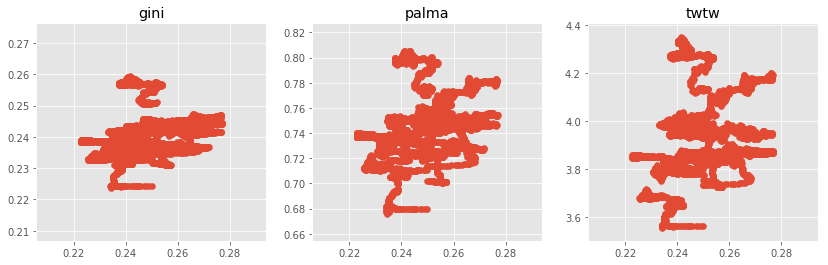

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[14,4])

ax1.scatter(chart_df['share_ch'], chart_df['gini'])
ax2.scatter(chart_df['share_ch'], chart_df['palma'])
ax3.scatter(chart_df['share_ch'], chart_df['twtw'])

ax1.set_title('gini')
ax2.set_title('palma')
ax3.set_title('twtw')

## Regression model: 

$c_{i,t} = \alpha_i + \beta_{i} C_{i,t} + \beta_{t} \delta_t + \epsilon_{i,t}$

In [38]:
cols = [x for x in chart_df.columns if x not in['gini', 'palma', 'twtw']]

In [40]:
gini_res = sm.OLS(endog=chart_df['gini'], exog=chart_df[cols], missing='drop').fit()
palma_res = sm.OLS(endog=chart_df['palma'], exog=chart_df[cols], missing='drop').fit()
twtw_res = sm.OLS(endog=chart_df['twtw'], exog=chart_df[cols], missing='drop').fit()

In [43]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[gini_res, palma_res, twtw_res],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['Gini', 'Palma', '20-20'],
                            info_dict=info_dict,
                            regressor_order=['const', 'share_ch'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

                    Table - OLS Regressions
                      Gini          Palma           20-20     
--------------------------------------------------------------
const            0.2058***      0.5722***      2.8969***      
                 (0.0025)       (0.0091)       (0.0635)       
share_ch         0.1233***      0.6107***      3.8064***      
                 (0.0055)       (0.0197)       (0.1383)       
time_1           0.0000         0.0002         0.0010         
                 (0.0030)       (0.0107)       (0.0753)       
time_10          0.0000         0.0002         0.0009         
                 (0.0030)       (0.0107)       (0.0753)       
time_100         0.0027         0.0108         0.0572         
                 (0.0030)       (0.0107)       (0.0753)       
time_1000        0.0066**       0.0293***      0.1187         
                 (0.0030)       (0.0107)       (0.0753)       
time_1001        0.0066**       0.0294***      0.1199         
           

In [45]:
from linearmodels import PanelOLS
from linearmodels import RandomEffects

SyntaxError: invalid syntax (model.py, line 135)

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [20]:
chart_df.head(2)

,gini,palma,seed,share_ch,time,twtw,const
0,0.232774,0.710790,0,0.249974,0,3.802262,1
1,0.232774,0.710793,0,0.249061,1,3.802294,1


In [29]:
chart_df["Intercept"] = 1
exog = chart_df[["Intercept", "time", 'share_ch']]

In [30]:
gini_re = sm.MixedLM(chart_df["gini"], exog, groups=chart_df["seed"], exog_re=exog["Intercept"]).fit()

print(gini_re.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: gini      
No. Observations: 4200    Method:             REML      
No. Groups:       4       Scale:              0.0000    
Min. group size:  1050    Likelihood:         25197.6279
Max. group size:  1050    Converged:          Yes       
Mean group size:  1050.0                                
--------------------------------------------------------
              Coef. Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     0.234    0.002 116.477 0.000  0.231  0.238
time          0.000    0.000  99.384 0.000  0.000  0.000
share_ch      0.016    0.001  11.793 0.000  0.013  0.018
Intercept Var 0.000    0.020                            



In [34]:
palma_re = sm.MixedLM(chart_df["palma"], exog, groups=chart_df["seed"], exog_re=exog["Intercept"]).fit()

print(palma_re.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: palma     
No. Observations: 4200    Method:             REML      
No. Groups:       4       Scale:              0.0000    
Min. group size:  1050    Likelihood:         18480.5520
Max. group size:  1050    Converged:          Yes       
Mean group size:  1050.0                                
--------------------------------------------------------
              Coef. Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     0.721    0.010  74.581 0.000  0.702  0.740
time          0.000    0.000 114.635 0.000  0.000  0.000
share_ch      0.061    0.007   9.308 0.000  0.048  0.073
Intercept Var 0.000    0.096                            



In [36]:
twtw_re = sm.MixedLM(chart_df["twtw"], exog, groups=chart_df["seed"], exog_re=exog["Intercept"]).fit()

print(twtw_re.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: twtw      
No. Observations: 4200    Method:             REML      
No. Groups:       4       Scale:              0.0003    
Min. group size:  1050    Likelihood:         11206.4838
Max. group size:  1050    Converged:          Yes       
Mean group size:  1050.0                                
--------------------------------------------------------
               Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      3.643    0.064 56.633 0.000  3.517  3.769
time           0.000    0.000 62.584 0.000  0.000  0.000
share_ch       1.042    0.037 28.272 0.000  0.970  1.114
Intercept Var  0.016    0.750                           

